# **Data Preparation & Preprocessing**

## Import module

In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, unicodedata, emoji
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from underthesea import word_tokenize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("UMAP not available. Install with: pip install umap-learn")


UMAP not available. Install with: pip install umap-learn


Set style for plot

In [139]:
sns.set_theme(
    style="whitegrid",
    context='notebook'
)

## Load & filter data

### Processing file

In [140]:
from typing import Any

def process_dataframe(df:dict[str, pd.DataFrame] | None, *process:Any):
    for key in df.keys():
        if process is None: continue
        for func in process:
            func(df, key)

In [141]:
def load_file(df:dict[str, pd.DataFrame], key:str):
    df[key] = pd.read_json(f'archive/UIT-VSFC-{key}.json')
    df[key] = df[key][(df[key]['topic'] == 'lecturer') & (df[key]['sentiment'] != 'neutral')].drop('topic', axis=1)
    df[key].reset_index(drop=True, inplace=True)
    print(f'{key.capitalize()} size: {df[key].shape}')
    display(df[key].head())

In [142]:
df = {
    'train': pd.DataFrame(),
    'dev': pd.DataFrame(),
    'test': pd.DataFrame()
}

try:
    process_dataframe(df, load_file)
except Exception as e:
    print(f"Errors: {e}")

Train size: (7980, 2)


,sentence,sentiment
0,"nhiệt tình giảng dạy , gần gũi với sinh viên .",positive
1,chưa áp dụng công nghệ thông tin và các thiết ...,negative
2,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",positive
3,"giảng viên đảm bảo thời gian lên lớp , tích cự...",positive
4,thầy rất tận tình và đi dạy rất đúng giờ .,positive


Dev size: (1119, 2)


,sentence,sentiment
0,giảng buồn ngủ .,negative
1,"giáo viên vui tính , tận tâm .",positive
2,"giảng viên nên giao bài tập nhiều hơn , chia n...",negative
3,"giảng viên cần giảng bài chi tiết hơn , đi sâu...",negative
4,nên có giảng viên nước ngoài dạy để sinh viên ...,negative


Test size: (2216, 2)


,sentence,sentiment
0,nói tiếng anh lưu loát .,positive
1,giáo viên rất vui tính .,positive
2,cô max có tâm .,positive
3,"giảng bài thu hút , dí dỏm .",positive
4,"giáo viên không giảng dạy kiến thức , hướng dẫ...",negative


### Label encoding

In [143]:
label_encoder = LabelEncoder()

df['train']['sentiment_encoded'] = label_encoder.fit_transform(df['train']['sentiment'])
df['dev']['sentiment_encoded'] = label_encoder.transform(df['dev']['sentiment'])
df['test']['sentiment_encoded'] = label_encoder.transform(df['test']['sentiment'])

for label, encoded in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{label}: {encoded}")

print("Phân phối nhãn sau khi encode:")
print("Train:")
print(df['train']['sentiment_encoded'].value_counts().sort_index())
print("Dev:")
print(df['dev']['sentiment_encoded'].value_counts().sort_index())
print("Test:")
print(df['test']['sentiment_encoded'].value_counts().sort_index())

negative: 0
positive: 1
Phân phối nhãn sau khi encode:
Train:
sentiment_encoded
0    2909
1    5071
Name: count, dtype: int64
Dev:
sentiment_encoded
0    405
1    714
Name: count, dtype: int64
Test:
sentiment_encoded
0     791
1    1425
Name: count, dtype: int64


### EDA

Word cloud funtion

In [144]:
def getWordCloud(words, title):
    text = ' '.join(words)
    wordcloud = WordCloud(
        width=500,
        height=250,
        colormap='viridis',
        background_color='white',
        random_state=123
    ).generate(text)
    
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=20, pad=16, color="#222")
    plt.tight_layout(pad=0)
    plt.show()

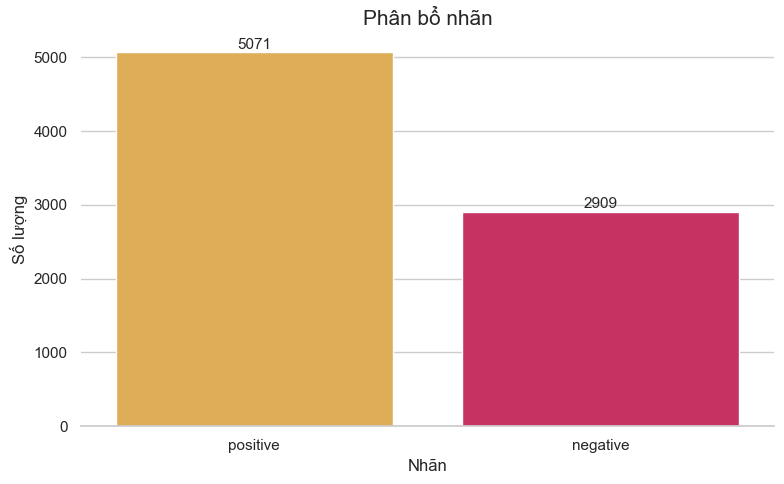

Quantity of each label:
positive: 5071 (63.55%)
negative: 2909 (36.45%)


In [145]:
sentiment_counts = df['train']['sentiment'].value_counts()

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=sentiment_counts.index,
    y=sentiment_counts.values,
    hue=sentiment_counts.index,
    palette={'positive': '#F4B342', 'negative': '#DE1A58'}
)
plt.xlabel('Nhãn', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)
plt.title('Phân bổ nhãn', fontsize=15)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

for i, count in enumerate(sentiment_counts.values):
    plt.text(i, count + 2, str(count), ha='center', va='bottom', fontsize=11)

sns.despine(left=True)
plt.tight_layout()
plt.show()

print("Quantity of each label:")
for sentiment, count in sentiment_counts.items():
    print(f"{sentiment}: {count} ({count/len(df['train'])*100:.2f}%)")

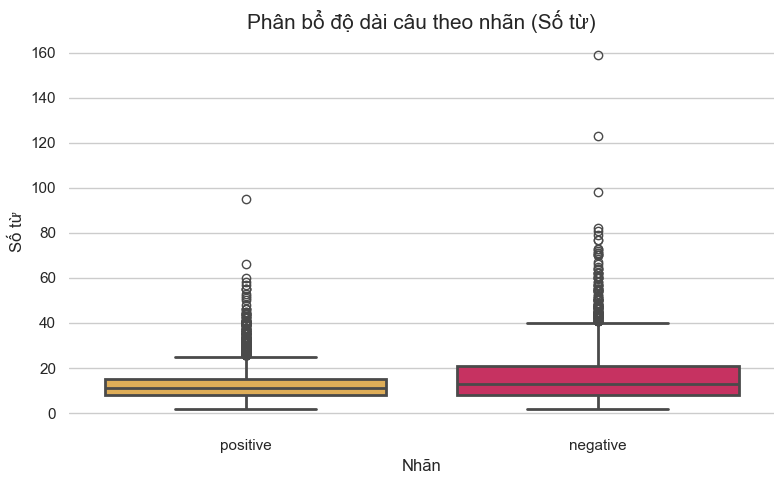

In [146]:
plt.figure(figsize=(8, 5))

df['train']['word_count'] = df['train']['sentence'].astype(str).apply(lambda x: len(x.split()))
ax = sns.boxplot(
    x='sentiment',
    y='word_count',
    data=df['train'],
    linewidth=2,
    hue='sentiment',
    palette={'positive': '#F4B342', 'negative': '#DE1A58'}
)

sns.despine(left=True, bottom=True)
ax.set_title('Phân bổ độ dài câu theo nhãn (Số từ)', fontsize=15)
ax.set_xlabel('Nhãn', fontsize=12)
ax.set_ylabel('Số từ', fontsize=12)
plt.tight_layout()
plt.show()

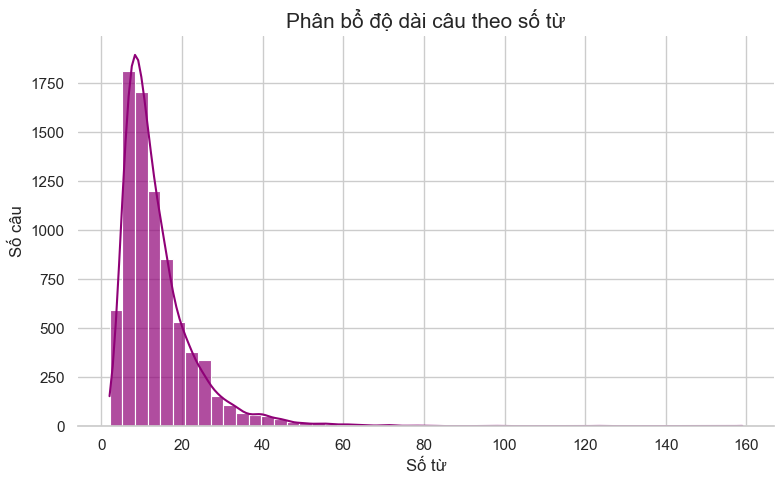

In [147]:
plt.figure(figsize=(8, 5))
sns.histplot(
    df['train']['word_count'],
    color='#8F0177',
    bins=50,
    alpha=0.7,
    kde=True
)
plt.title('Phân bổ độ dài câu theo số từ', fontsize=15)
plt.xlabel('Số từ', fontsize=12)
plt.ylabel('Số câu', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
sns.despine(left=True)
plt.tight_layout()
plt.show()


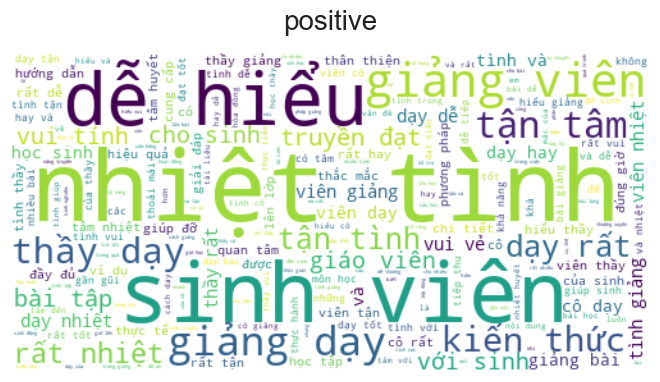

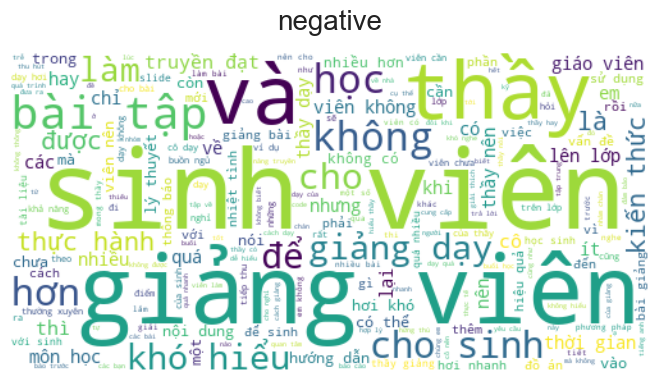

In [148]:
labels = df['train']['sentiment'].value_counts().index.tolist()

for label in labels:
    word_list = []

    for senc in df['train'][df['train']['sentiment'] == label]['sentence']:
        if isinstance(senc, list):
            merged = ' '.join(senc)
        else:
            merged = senc
        word_list.append(merged)

    getWordCloud(word_list, label)

In [149]:
stats_words = df['train'].groupby('sentiment')['word_count'].agg(['mean', 'median', 'std', 'min', 'max']).round(2)
stats_words.columns = ['Trung bình', 'Trung vị', 'Độ lệch chuẩn', 'Tối thiểu', 'Tối đa']

print("Thống kê số từ theo nhãn:")
display(stats_words)

Thống kê số từ theo nhãn:


,Trung bình,Trung vị,Độ lệch chuẩn,Tối thiểu,Tối đa
sentiment,,,,,
negative,16.37,13.0,11.77,2,159
positive,12.37,11.0,7.00,2,95


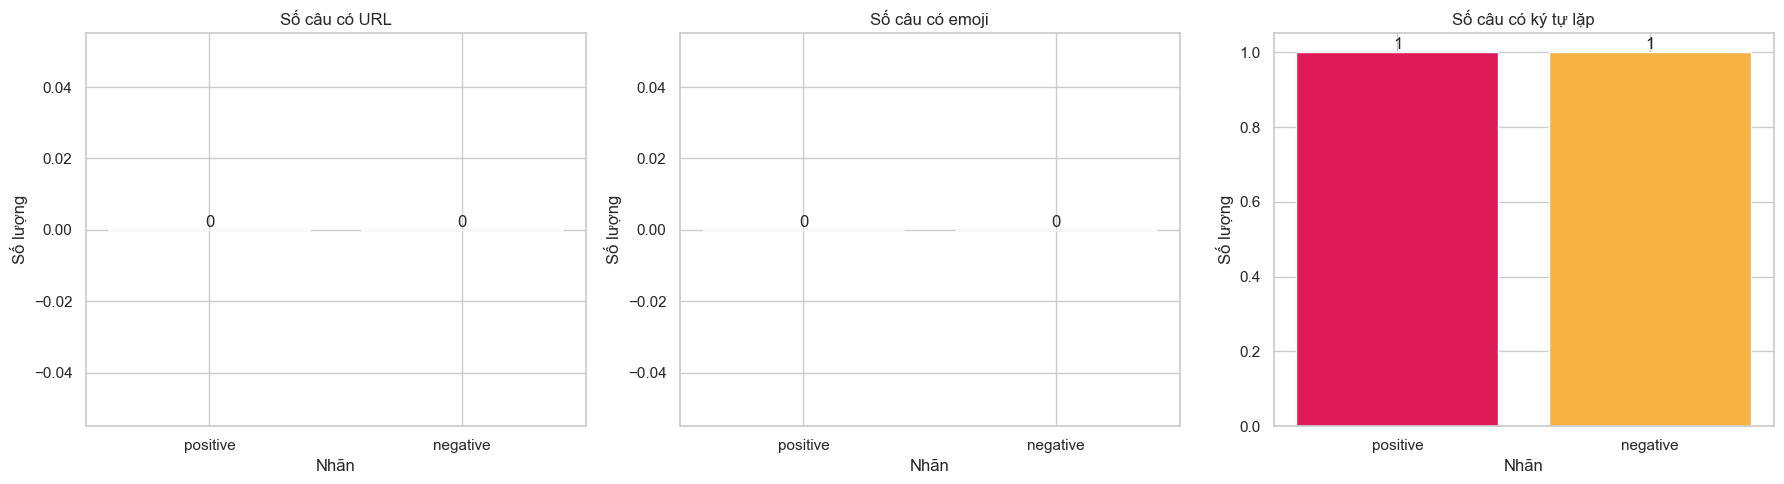

In [150]:
def has_url(text):
    if not isinstance(text, str):
        return False

    url_pattern = r'https?://\S+|www\.\S+'
    return bool(re.search(url_pattern, text))

def has_emoji(text):
    if not isinstance(text, str):
        return False

    try:
        return emoji.emoji_count(text) > 0
    except:
        emoji_pattern = re.compile(
            "["
            "\U0001F600-\U0001F64F"  # emoticons
            "\U0001F300-\U0001F5FF"  # symbols & pictographs
            "\U0001F680-\U0001F6FF"  # transport & map symbols
            "\U0001F1E0-\U0001F1FF"  # flags (iOS)
            "\U00002702-\U000027B0"
            "\U000024C2-\U0001F251"
            "]+",
            flags=re.UNICODE
        )

        return bool(emoji_pattern.search(text))

def has_repeated_chars(text):
    if not isinstance(text, str):
        return False

    return bool(re.search(r'(.)\1{2,}', text))

# Không thêm cột! Xử lý và tổng hợp trên-the-fly
feature_funcs = [("URL", has_url), ("emoji", has_emoji), ("ký tự lặp", has_repeated_chars)]
special_features = {}
for label in df['train']['sentiment'].unique():
    mask = df['train']['sentiment'] == label
    sent_texts = df['train'].loc[mask, 'sentence']
    for feat_name, feat_func in feature_funcs:
        count = sent_texts.apply(feat_func).sum()
        special_features.setdefault(feat_name, {})[label] = count

special_features_df = pd.DataFrame(special_features).fillna(0).astype(int)
special_features_df = special_features_df.reindex(df['train']['sentiment'].unique())

# Visualize bằng bar chart mà không cần cột trong dataframe
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (feat_name, _) in enumerate(feature_funcs):
    feature_counts = special_features_df[feat_name]
    axes[idx].bar(feature_counts.index, feature_counts.values, color=sns.color_palette({'#F4B342', '#DE1A58'}, len(feature_counts)))
    axes[idx].set_title(f'Số câu có {feat_name}')
    axes[idx].set_xlabel('Nhãn')
    axes[idx].set_ylabel('Số lượng')
    for i, v in enumerate(feature_counts.values):
        axes[idx].text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Pre-processing text

Xử lý dấu câu

In [151]:
def remove_punctuation(text:str) -> str:
    import string
    return text.translate(str.maketrans('', '', string.punctuation))

Stop words

In [152]:
import requests

url_stop = "https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt"
path_stop = "archive/vietnamese-stopwords.txt"
path_sent = "archive/vietnamese-semtimentwords.txt"
stopwords = set(requests.get(url_stop).text.strip().replace(' ', '_').split('\n') + open(path_stop, 'r', encoding='utf-8').read().split('\n'))
sentwords = set(open(path_sent, 'r', encoding='utf-8').read().split('\n'))
stopwords = stopwords - sentwords

def normalize_stopwords(text:str):
    tokens = text.split()
    clean_tokens = [word for word in tokens if word not in stopwords]

    return ' '.join(clean_tokens)

Normalize unicode

In [153]:
def normalize_unicode(text:str):
    return unicodedata.normalize('NFC', text)

Duplicate characters handling

In [154]:
def remove_duplicate_characters(text:str):
    return re.sub(r'(.)\1+', r'\1', text)

Dataset specific regex

In [155]:
def remove_specific_unnormalized(text:str):
    text = re.sub(r'wzjwz\d+', ' ', text)
    text = re.sub(r'colon\w+', ' ', text)
    text = re.sub(r'(doubledot)|(fraction)|(vdotv)', ' ', text)
    return text

In [156]:
def preprocess_text(text):
    if not isinstance(text, str): return ""
    text = text.lower().strip() # Lowercasing & Processing space
    text = normalize_unicode(text)
    text = remove_duplicate_characters(text)
    text = remove_punctuation(text)
    text = word_tokenize(text.lower(), format="text")
    text = normalize_stopwords(text)
    return text

Áp dụng các biện pháp xử lý

In [157]:
df['train']["sentence_process"] = df['train']["sentence"].apply(preprocess_text)
df['dev']["sentence_process"] = df['dev']["sentence"].apply(preprocess_text)
df['test']["sentence_process"] = df['test']["sentence"].apply(preprocess_text)

display(df['train'].head())
display(df['dev'].head())
display(df['test'].head())

,sentence,sentiment,sentiment_encoded,word_count,sentence_process
0,"nhiệt tình giảng dạy , gần gũi với sinh viên .",positive,1,11,nhiệt_tình gần_gũi
1,chưa áp dụng công nghệ thông tin và các thiết ...,negative,0,18,chưa áp_dụng công_nghệ_thông_tin thiết_bị
2,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",positive,1,15,hay có nhiều
3,"giảng viên đảm bảo thời gian lên lớp , tích cự...",positive,1,28,tích_cực trả_lời câu thường_xuyên câu
4,thầy rất tận tình và đi dạy rất đúng giờ .,positive,1,11,rất tận_tình rất


,sentence,sentiment,sentiment_encoded,sentence_process
0,giảng buồn ngủ .,negative,0,buồn ngủ
1,"giáo viên vui tính , tận tâm .",positive,1,vui_tính tận_tâm
2,"giảng viên nên giao bài tập nhiều hơn , chia n...",negative,0,nên giao nhiều hơn chia giảng_kỹ trọng_tâm hiệ...
3,"giảng viên cần giảng bài chi tiết hơn , đi sâu...",negative,0,chi_tiết hơn đi_sâu hơn code chạy thử chương_t...
4,nên có giảng viên nước ngoài dạy để sinh viên ...,negative,0,nên có nước_ngoài có giao_tiếp


,sentence,sentiment,sentiment_encoded,sentence_process
0,nói tiếng anh lưu loát .,positive,1,tiếng lưu_loát
1,giáo viên rất vui tính .,positive,1,rất vui_tính
2,cô max có tâm .,positive,1,max có tâm
3,"giảng bài thu hút , dí dỏm .",positive,1,thu_hút dí dỏm
4,"giáo viên không giảng dạy kiến thức , hướng dẫ...",negative,0,không hướng_dẫn


### Sau tiền xử lý

Word Cloud

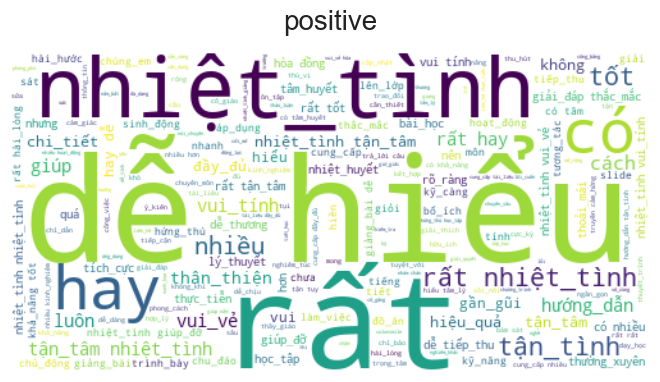

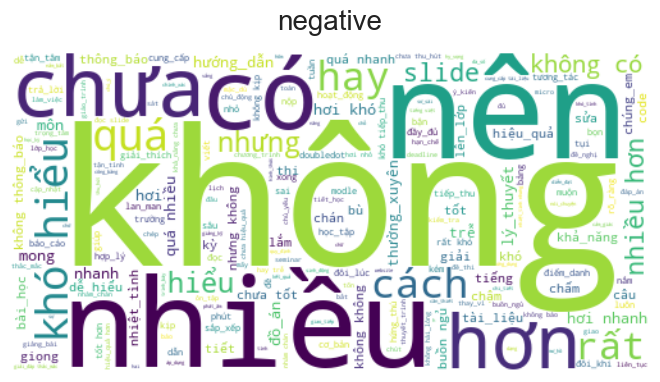

In [158]:
labels = df['train']['sentiment'].value_counts().index.tolist()

for label in labels:
    word_list = []

    for senc in df['train'][df['train']['sentiment'] == label]['sentence_process']:
        if isinstance(senc, list):
            merged = ' '.join(senc)
        else:
            merged = senc
        word_list.append(merged)

    getWordCloud(word_list, label)

## Feature Extraction

TF-IDF vs N-grams

In [159]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [160]:
X_train = df['train']['sentence_process']
X_dev = df['dev']['sentence_process']
X_test = df['test']['sentence_process']

In [161]:
y_train = df['train']['sentiment_encoded']
y_dev = df['dev']['sentiment_encoded']
y_test = df['test']['sentiment_encoded']

In [162]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=3)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_dev_tfidf = tfidf_vectorizer.transform(X_dev)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [163]:
print(f"Kích thước tập huấn luyện (Training Set): {X_train_tfidf.shape}")
print(f"Kích thước tập huấn luyện (Validation Set): {X_dev_tfidf.shape}")
print(f"Kích thước tập kiểm thử (Test Set): {X_test_tfidf.shape}")
print(f"Tổng số đặc trưng (từ vựng và n-grams) được sử dụng: {X_train_tfidf.shape[1]}")

Kích thước tập huấn luyện (Training Set): (7980, 2600)
Kích thước tập huấn luyện (Validation Set): (1119, 2600)
Kích thước tập kiểm thử (Test Set): (2216, 2600)
Tổng số đặc trưng (từ vựng và n-grams) được sử dụng: 2600


# **Training model**

## Import module

In [164]:
import time
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import learning_curve

Models configuration

In [197]:
models = {
    'Lo.R': {
        'instance': LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            solver='liblinear',
            n_jobs=-1
        ),
        'threshold': 0.5
    },
    'Naive Bayes': {
        'instance': MultinomialNB(),
        'threshold': 0.5
    },
    'Linear-SVM': {
        'instance': LinearSVC(
            class_weight='balanced',
            max_iter=1000,
            dual=False
        ),
        'threshold': 0.5
    }
}

# Lưu ý: Khi chạy vòng lặp training, bạn cần cập nhật lại code như sau:
# for name, model_info in models.items():
#     model = model_info['instance']
#     model.fit(X_train_tfidf, y_train)
#     ...

### Train models

In [198]:
# Dictionary to store trained models and results
trained_models = {}
results = {}

print("Training models...")

for name, model_info in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Train the model
    model = model_info['instance']
    model.fit(X_train_tfidf, y_train)
    trained_models[name] = model
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Predictions
    y_train_pred = model.predict(X_train_tfidf)
    y_dev_pred = model.predict(X_dev_tfidf)
    y_test_pred = model.predict(X_test_tfidf)
    
    # Calculate metrics
    results[name] = {
        'train': {
            'accuracy': accuracy_score(y_train, y_train_pred),
            'precision': precision_score(y_train, y_train_pred, average='weighted'),
            'recall': recall_score(y_train, y_train_pred, average='weighted'),
            'f1': f1_score(y_train, y_train_pred, average='weighted')
        },
        'dev': {
            'accuracy': accuracy_score(y_dev, y_dev_pred),
            'precision': precision_score(y_dev, y_dev_pred, average='weighted'),
            'recall': recall_score(y_dev, y_dev_pred, average='weighted'),
            'f1': f1_score(y_dev, y_dev_pred, average='weighted')
        },
        'test': {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred, average='weighted'),
            'recall': recall_score(y_test, y_test_pred, average='weighted'),
            'f1': f1_score(y_test, y_test_pred, average='weighted')
        },
        'predictions': {
            'train': y_train_pred,
            'dev': y_dev_pred,
            'test': y_test_pred
        },
        'training_time': training_time
    }

print("All models trained successfully!")


Training models...

Training Lo.R...
Training completed in 0.02 seconds

Training Naive Bayes...
Training completed in 0.00 seconds

Training Linear-SVM...
Training completed in 0.02 seconds
All models trained successfully!


c:\Users\Dell\anaconda3\envs\my_env\lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


## Evaluation

### Results comparison

In [199]:
# Create results DataFrame for comparison
comparison_data = []
for model_name, result in results.items():
    for dataset in ['train', 'dev', 'test']:
        comparison_data.append({
            'Model': model_name,
            'Dataset': dataset,
            'Accuracy': result[dataset]['accuracy'],
            'Precision': result[dataset]['precision'],
            'Recall': result[dataset]['recall'],
            'F1-Score': result[dataset]['f1']
        })

results_df = pd.DataFrame(comparison_data)
display(results_df)

,Model,Dataset,Accuracy,Precision,Recall,F1-Score
0,Lo.R,train,0.946742,0.947825,0.946742,0.946990
1,Lo.R,dev,0.935657,0.935916,0.935657,0.935758
2,Lo.R,test,0.913357,0.915928,0.913357,0.913990
3,Naive Bayes,train,0.941729,0.941600,0.941729,0.941635
4,Naive Bayes,dev,0.927614,0.927409,0.927614,0.927220
5,Naive Bayes,test,0.911552,0.911836,0.911552,0.911674
6,Linear-SVM,train,0.965414,0.965799,0.965414,0.965508
7,Linear-SVM,dev,0.941019,0.940863,0.941019,0.940889
8,Linear-SVM,test,0.914711,0.915790,0.914711,0.915062


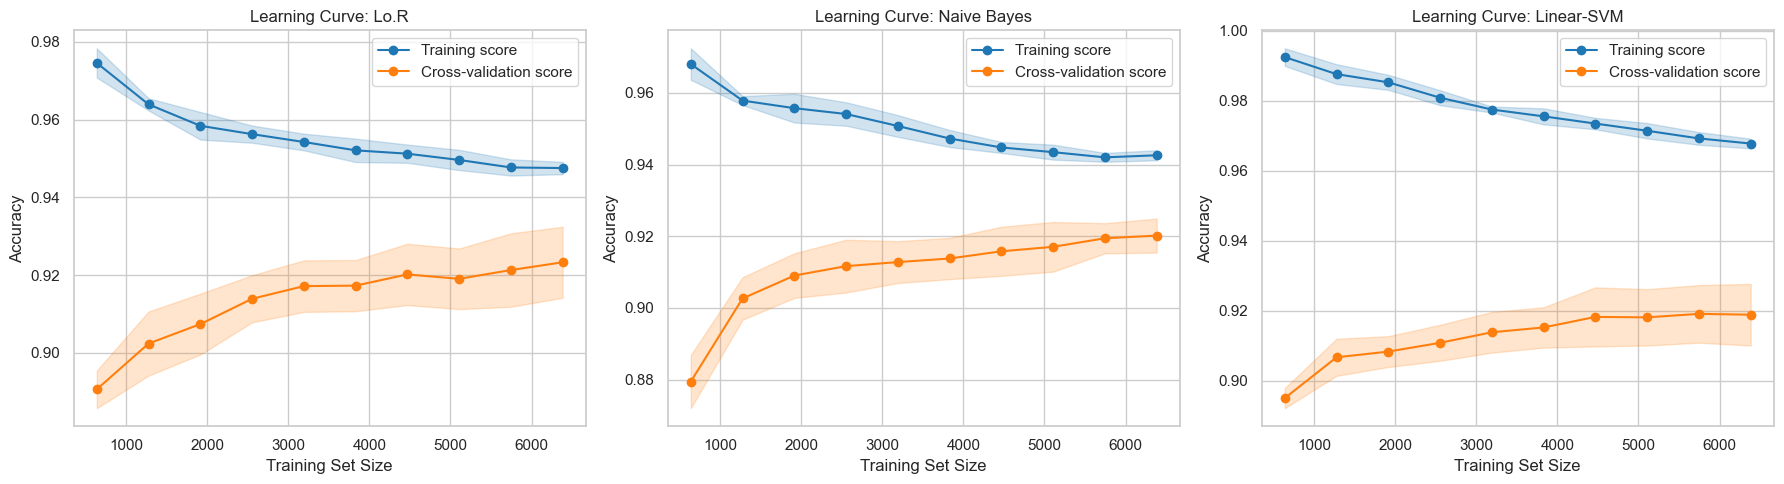

In [200]:
plt.figure(figsize=(18, 5))

for idx, (model_name, model) in enumerate(trained_models.items()):
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X_train_tfidf,
        y_train,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=42
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.subplot(1, len(trained_models), idx + 1)
    plt.grid(True)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="tab:blue")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="tab:orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="tab:blue", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="tab:orange", label="Cross-validation score")
    plt.title(f"Learning Curve: {model_name}")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")

plt.tight_layout()
plt.show()

### Detailed classification reports

In [201]:
for model_name in trained_models.keys():
    print(f"\n{'='*60}")
    print(f"Model: {model_name}")
    print(f"{'='*60}")
    
    for dataset_name, y_true, y_pred in [
        ('Train', y_train, results[model_name]['predictions']['train']),
        ('Dev', y_dev, results[model_name]['predictions']['dev']),
        ('Test', y_test, results[model_name]['predictions']['test'])
    ]:
        print(f"{dataset_name} Set Classification Report:")
        print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=4))


Model: Lo.R
Train Set Classification Report:
              precision    recall  f1-score   support

    negative     0.9077    0.9505    0.9286      2909
    positive     0.9708    0.9446    0.9575      5071

    accuracy                         0.9467      7980
   macro avg     0.9393    0.9475    0.9431      7980
weighted avg     0.9478    0.9467    0.9470      7980

Dev Set Classification Report:
              precision    recall  f1-score   support

    negative     0.9051    0.9185    0.9118       405
    positive     0.9534    0.9454    0.9494       714

    accuracy                         0.9357      1119
   macro avg     0.9292    0.9319    0.9306      1119
weighted avg     0.9359    0.9357    0.9358      1119

Test Set Classification Report:
              precision    recall  f1-score   support

    negative     0.8528    0.9153    0.8829       791
    positive     0.9510    0.9123    0.9312      1425

    accuracy                         0.9134      2216
   macro avg     0.

### Confusion matrices

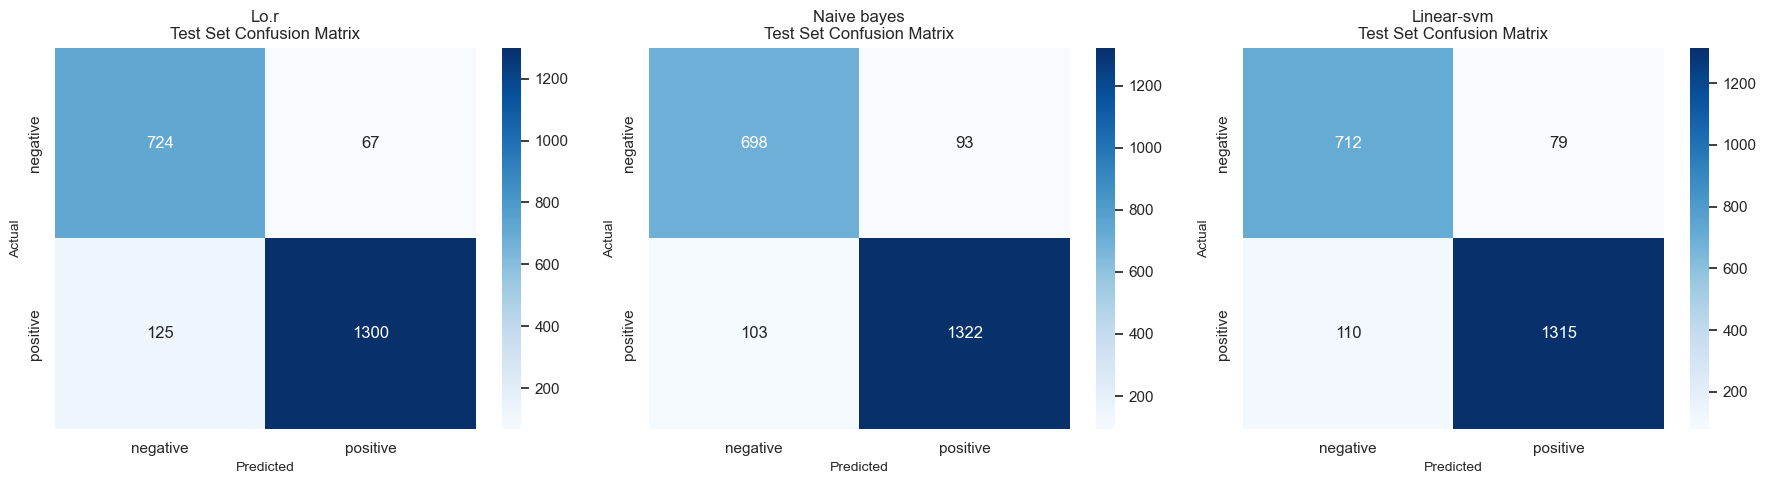

In [202]:
# Plot confusion matrices for test set
fig, axes = plt.subplots(1, len(trained_models), figsize=(6*len(trained_models), 5))

if len(trained_models) == 1:
    axes = [axes]

for idx, (model_name, model) in enumerate(trained_models.items()):
    y_test_pred = results[model_name]['predictions']['test']
    cm = confusion_matrix(y_test, y_test_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    axes[idx].set_title(f'{model_name.capitalize()}\nTest Set Confusion Matrix', 
                        fontsize=12)
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)

plt.tight_layout()
plt.show()


## Hyperparameter Tuning cho 3 mô hình
Thực hiện GridSearchCV cho Logistic Regression, Linear SVM và Multinomial Naive Bayes.
So sánh hiệu quả dựa trên F1-score.

In [204]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd

# 1. Định nghĩa cấu trúc Model kèm ngưỡng Threshold mặc định
model_configs = {
    'Logistic Regression': {
        'pipeline': Pipeline([
            ('tfidf', TfidfVectorizer(min_df=3)),
            ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1))
        ]),
        'threshold': 0.5 
    },
    'Naive Bayes': {
        'pipeline': Pipeline([
            ('tfidf', TfidfVectorizer(min_df=3)),
            ('clf', MultinomialNB())
        ]),
        'threshold': 0.5
    },
    'Linear SVM': {
        'pipeline': Pipeline([
            ('tfidf', TfidfVectorizer(min_df=3)),
            ('clf', LinearSVC(class_weight='balanced', max_iter=5000, dual='auto'))
        ]),
        'threshold': 0.5
    }
}

# 2. Định nghĩa lưới tham số tuning (Giữ nguyên)
param_grids = {
    'Logistic Regression': {
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'tfidf__use_idf': [True, False],
        'clf__C': [0.1, 1, 10, 100],
        'clf__solver': ['liblinear', 'lbfgs']
    },
    'Naive Bayes': {
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'tfidf__max_features': [None, 5000, 10000],
        'clf__alpha': [0.001, 0.01, 0.1, 1, 10]
    },
    'Linear SVM': {
        'tfidf__ngram_range': [(1, 2), (1, 3)],
        'tfidf__norm': ['l1', 'l2'],
        'clf__C': [0.1, 0.5, 1, 5, 10],
        'clf__loss': ['hinge', 'squared_hinge']
    }
}

In [206]:
best_tuned_configs = {} # Lưu cả pipeline và threshold sau tuning
tuning_results = []

print("--- Đang thực hiện Grid Search cho các Pipeline ---\n")

for name, config in model_configs.items():
    print(f"Tuning {name}...")
    
    grid_search = GridSearchCV(
        config['pipeline'], 
        param_grids[name], 
        cv=5, 
        scoring='f1_weighted', 
        n_jobs=-1, 
        verbose=1
    )
    
    grid_search.fit(df['train']['sentence_process'], y_train)
    
    # Lưu lại kết quả gồm Pipeline tốt nhất và Threshold mặc định
    best_tuned_configs[name] = {
        'pipeline': grid_search.best_estimator_,
        'threshold': config['threshold'] 
    }
    
    tuning_results.append({
        'Model': name,
        'Best_F1': grid_search.best_score_,
        'Params': grid_search.best_params_
    })

print("\n--- Tuning hoàn tất! ---")

--- Đang thực hiện Grid Search cho các Pipeline ---

Tuning Logistic Regression...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Tuning Naive Bayes...
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Tuning Linear SVM...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

--- Tuning hoàn tất! ---


In [ ]:
from sklearn.metrics import precision_recall_curve

def optimize_model_thresholds(configs, X_val, y_val):
    
    for name, config in configs.items():
        pipeline = config['pipeline']
        
        # Lấy xác suất
        if hasattr(pipeline.named_steps['clf'], 'predict_proba'):
            y_probs = pipeline.predict_proba(X_val)[:, 1]
        else:
            # Cho SVM
            d = pipeline.decision_function(X_val)
            y_probs = 1 / (1 + np.exp(-d))
            
        # Tìm threshold tốt nhất bằng Precision-Recall Curve
        precisions, recalls, thresholds = precision_recall_curve(y_val, y_probs)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        
        # Cập nhật threshold mới vào config
        new_threshold = thresholds[best_idx]
        configs[name]['threshold'] = new_threshold
        
        print(f"Model {name:20}: Ngưỡng mới = {new_threshold:.4f} (F1-Dev = {f1_scores[best_idx]:.4f})")

# Chạy tối ưu hóa
optimize_model_thresholds(best_tuned_configs, df['dev']['sentence_process'], y_dev)

--- Đang tìm ngưỡng (Threshold) tối ưu trên tập DEV ---

Model Logistic Regression : Ngưỡng mới = 0.5247 (F1-Dev = 0.9546)
Model Naive Bayes         : Ngưỡng mới = 0.4262 (F1-Dev = 0.9482)
Model Linear SVM          : Ngưỡng mới = 0.4732 (F1-Dev = 0.9545)


In [ ]:
# 1. Tạo DataFrame từ danh sách kết quả tuning
tuning_summary_df = pd.DataFrame(tuning_results)

# 2. Hiển thị bảng tổng hợp sắp xếp theo Score (Lưu ý: dùng tên cột 'Best_F1')
print("--- BẢNG TỔNG HỢP KẾT QUẢ GRID SEARCH ---")
display(tuning_summary_df.sort_values(by='Best_F1', ascending=False))

# 3. Xác định Model quán quân (Best of the best)
# Sử dụng idxmax trên cột 'Best_F1'
best_model_row = tuning_summary_df.loc[tuning_summary_df['Best_F1'].idxmax()]
best_model_name = best_model_row['Model']

# Lấy thông tin từ dict best_tuned_configs (đã bao gồm pipeline và threshold tối ưu)
winning_config = best_tuned_configs[best_model_name]
best_model = winning_config['pipeline']
optimal_threshold = winning_config['threshold']

print(f"\n🏆 MODEL CHIẾN THẮNG: {best_model_name.upper()}")
print(f"   - F1-Score (Validation): {best_model_row['Best_F1']:.4f}")
print(f"   - Ngưỡng tối ưu (Optimal Threshold): {optimal_threshold:.4f}")
print(f"   - Tham số tốt nhất: {best_model_row['Params']}")

--- BẢNG TỔNG HỢP KẾT QUẢ GRID SEARCH ---


,Model,Best_F1,Params
2,Linear SVM,0.924166,"{'clf__C': 0.1, 'clf__loss': 'squared_hinge', ..."
0,Logistic Regression,0.923001,"{'clf__C': 10, 'clf__solver': 'lbfgs', 'tfidf_..."
1,Naive Bayes,0.917322,"{'clf__alpha': 1, 'tfidf__max_features': None,..."



🏆 MODEL CHIẾN THẮNG: LINEAR SVM
   - F1-Score (Validation): 0.9242
   - Ngưỡng tối ưu (Optimal Threshold): 0.4732
   - Tham số tốt nhất: {'clf__C': 0.1, 'clf__loss': 'squared_hinge', 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2'}


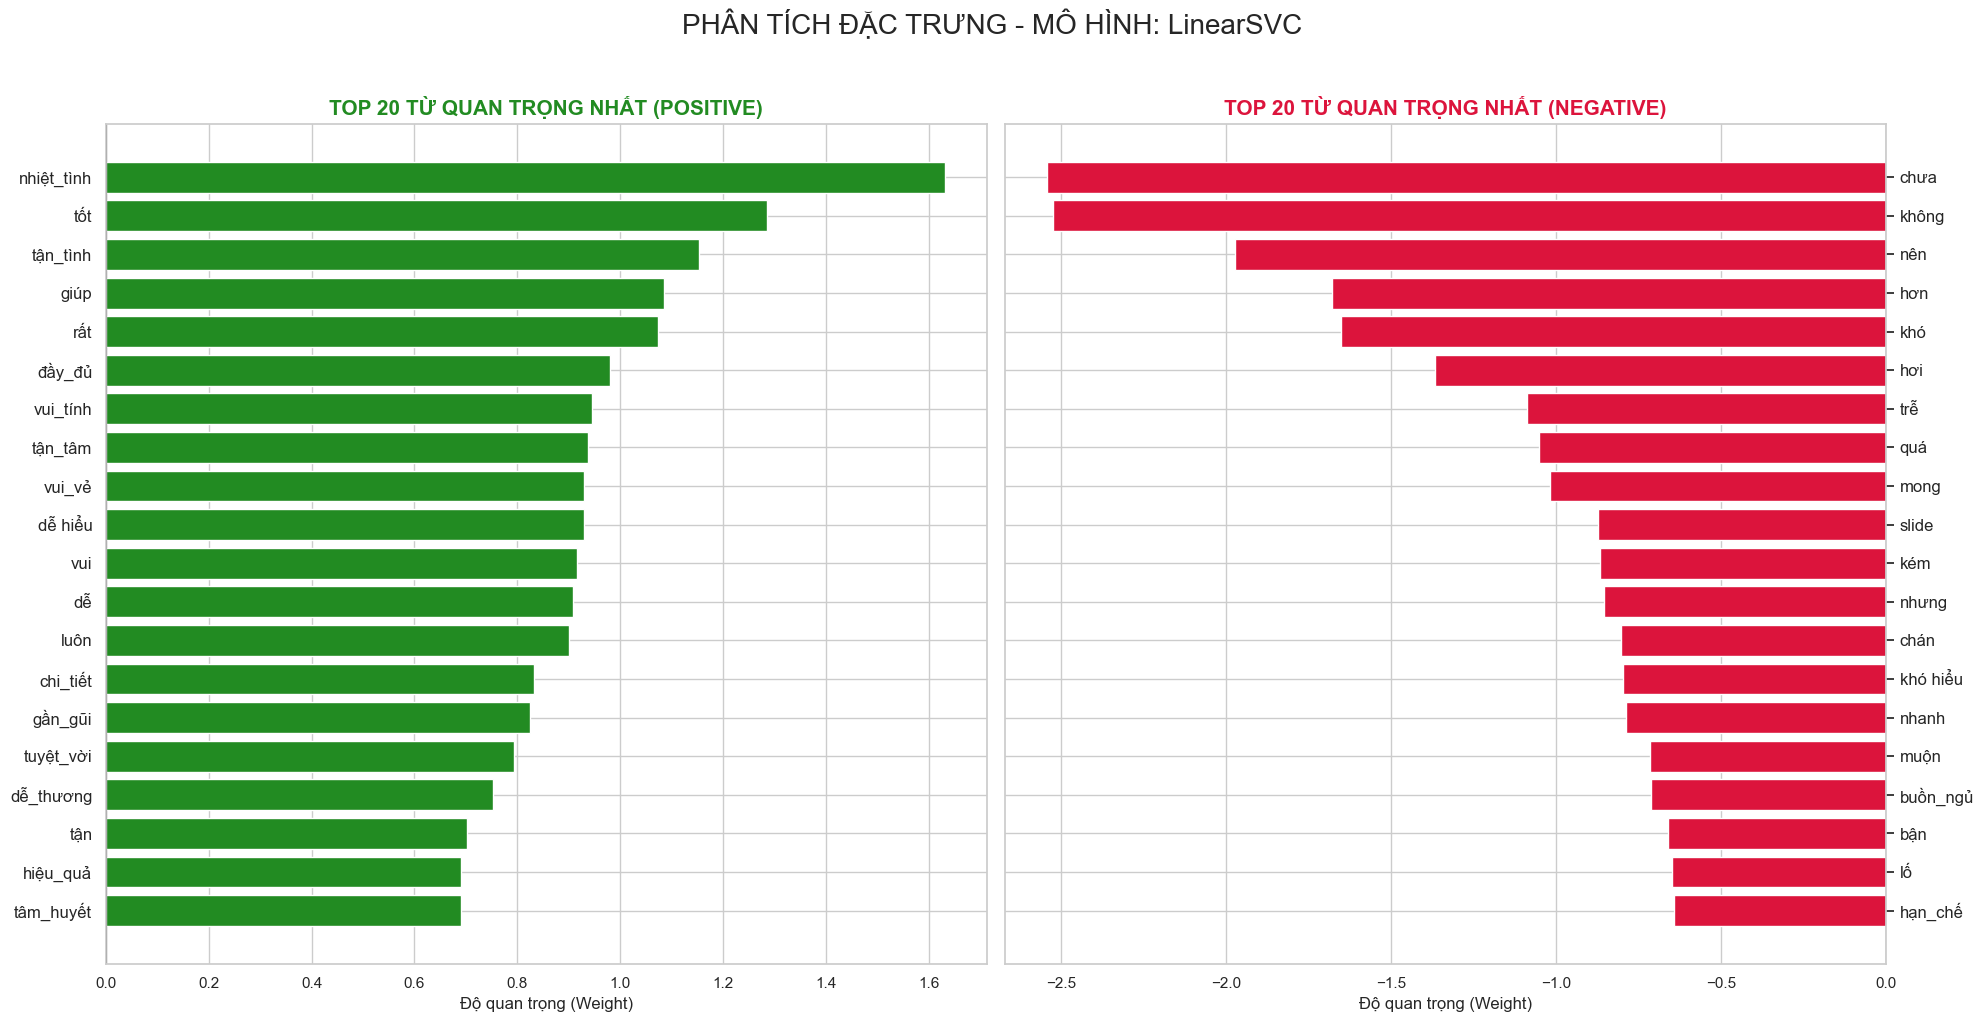

In [210]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline

def plot_class_specific_features_v2(pipeline_model, n=20):
    # 1. Tách Vectorizer và Classifier từ Pipeline
    if isinstance(pipeline_model, Pipeline):
        vectorizer = pipeline_model.named_steps['tfidf']
        classifier = pipeline_model.named_steps['clf']
    else:
        print("Lỗi: Đối tượng truyền vào không phải là Pipeline.")
        return

    # 2. Lấy tên các đặc trưng (từ vựng)
    feature_names = np.array(vectorizer.get_feature_names_out())
    
    # 3. Lấy trọng số (Coefficients) dựa trên loại Model
    if hasattr(classifier, 'coef_'):
        # Dành cho SVM và Logistic Regression
        coefs = classifier.coef_.toarray()[0] if hasattr(classifier.coef_, 'toarray') else classifier.coef_[0]
    elif hasattr(classifier, 'feature_log_prob_'):
        # Dành cho Naive Bayes (Sử dụng chênh lệch log probability giữa 2 nhãn)
        # Nhãn 1 (Positive) - Nhãn 0 (Negative)
        coefs = classifier.feature_log_prob_[1] - classifier.feature_log_prob_[0]
    else:
        print(f"Model {type(classifier).__name__} không hỗ trợ trích xuất trọng số đặc trưng.")
        return

    # 4. Xác định các chỉ số (indices) của đặc trưng hàng đầu
    top_pos_indices = np.argsort(coefs)[-n:][::-1] # Giảm dần
    top_neg_indices = np.argsort(coefs)[:n]        # Tăng dần (âm nhất lên đầu)
    
    # 5. Khởi tạo biểu đồ
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # --- Biểu đồ 1: Positive Features (Màu xanh) ---
    axes[0].barh(range(n), coefs[top_pos_indices], color='forestgreen', align='center')
    axes[0].set_yticks(range(n))
    axes[0].set_yticklabels(feature_names[top_pos_indices], fontsize=12)
    axes[0].invert_yaxis()
    axes[0].set_title(f"TOP {n} TỪ QUAN TRỌNG NHẤT (POSITIVE)", fontsize=15, fontweight='bold', color='forestgreen')
    axes[0].set_xlabel("Độ quan trọng (Weight)")
    axes[0].axvline(0, color='black', linewidth=0.8)

    # --- Biểu đồ 2: Negative Features (Màu đỏ) ---
    axes[1].barh(range(n), coefs[top_neg_indices], color='crimson', align='center')
    axes[1].set_yticks(range(n))
    axes[1].set_yticklabels(feature_names[top_neg_indices], fontsize=12)
    axes[1].invert_yaxis()
    axes[1].set_title(f"TOP {n} TỪ QUAN TRỌNG NHẤT (NEGATIVE)", fontsize=15, fontweight='bold', color='crimson')
    axes[1].set_xlabel("Độ quan trọng (Weight)")
    axes[1].axvline(0, color='black', linewidth=0.8)
    axes[1].yaxis.tick_right() # Đưa nhãn chữ sang bên phải cho cân đối
    
    plt.suptitle(f"PHÂN TÍCH ĐẶC TRƯNG - MÔ HÌNH: {type(classifier).__name__}", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

# GỌI HÀM
# Bây giờ bạn chỉ cần truyền duy nhất biến best_model (là Pipeline) vào là xong
try:
    plot_class_specific_features_v2(best_model, n=20)
except Exception as e:
    print(f"Có lỗi xảy ra: {e}")
    print("Mẹo: Đảm bảo bạn đã chạy cell 'final_best_model' trước đó.")

## test


In [ ]:
def predict_batch(texts, model_name=None):
    """
    Dự đoán sentiment cho nhiều câu cùng lúc bằng các mô hình đã Tuning (Pipeline).
    
    Parameters:
    -----------
    texts : list of str
        Danh sách các câu văn bản gốc cần dự đoán
    model_name : str, optional
        Tên mô hình ('Linear SVM', 'Logistic Regression', 'Naive Bayes'). 
        Nếu None, sử dụng best_model tốt nhất.
    """
    # 1. Chọn model
    if model_name is None:
        model = best_model  
        current_name = best_model_name
    else:
        # Sử dụng từ điển best_models đã tuning ở bước trước
        if model_name not in best_models:
            raise ValueError(f"Model '{model_name}' không tìm thấy. Danh sách: {list(best_models.keys())}")
        model = best_models[model_name]
        current_name = model_name
    
    # 2. Tiền xử lý văn bản
    # Lưu ý: Truyền vào biến stopwords nếu hàm của bạn yêu cầu
    processed_texts = [preprocess_text(text) for text in texts]
    
    # 3. Dự đoán (Pipeline tự động Vectorize văn bản đã qua xử lý)
    predictions = model.predict(processed_texts)
    sentiment_labels = label_encoder.inverse_transform(predictions)

    # 4. Tính toán xác suất (Probabilities)
    probabilities = None
    
    # Một số model không có predict_proba (như LinearSVC), cần dùng decision_function
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(processed_texts)
    elif hasattr(model, 'decision_function'):
        # Chuyển đổi score từ decision_function sang dạng xác suất xấp xỉ
        decisions = model.decision_function(processed_texts)
        if len(decisions.shape) == 1: # Nhị phân
            probabilities = []
            for d in decisions:
                # Công thức sigmoid xấp xỉ để đưa về khoảng [0, 1]
                p = 1 / (1 + np.exp(-d))
                probabilities.append([1-p, p])
            probabilities = np.array(probabilities)
        else: # Đa lớp (nếu có)
            exp_decisions = np.exp(decisions)
            probabilities = exp_decisions / np.sum(exp_decisions, axis=1, keepdims=True)

    # 5. Đóng gói kết quả vào DataFrame
    results = pd.DataFrame({
        'Text': texts,
        'Processed Text': processed_texts,
        'Predicted Sentiment': sentiment_labels,
        'Model Used': current_name
    })

    # Thêm các cột xác suất nếu có
    if probabilities is not None:
        for idx, label in enumerate(label_encoder.classes_):
            results[f'Probability_{label}'] = probabilities[:, idx]
    
    return results

# --- TEST THỬ VỚI CÁC CÂU MỚI ---
test_sentences = [
    "Thầy dạy rất hay và nhiệt tình",
    "Bài giảng hơi buồn ngủ, cần cải thiện thêm",
    "Cơ sở vật chất của trường rất tuyệt vời",
    "Giảng viên thường xuyên đi muộn"
]

# Chạy dự đoán bằng best model
final_predictions = predict_batch(test_sentences)
display(final_predictions)

,Text,Processed Text,Predicted Sentiment,Model Used,Probability_negative,Probability_positive
0,Thầy dạy rất hay và nhiệt tình,rất hay nhiệt_tình,positive,Linear SVM,0.197458,0.802542
1,"Bài giảng hơi buồn ngủ, cần cải thiện thêm",giảng_hơi buồn_ngủ cải_thiện,negative,Linear SVM,0.666599,0.333401
2,Cơ sở vật chất của trường rất tuyệt vời,cơ_sở vật_chất trường rất tuyệt_vời,positive,Linear SVM,0.387792,0.612208
3,Giảng viên thường xuyên đi muộn,thường_xuyên muộn,negative,Linear SVM,0.647549,0.352451


In [212]:
batch_texts = [
    "Giảng viên rất nhiệt tình và có phương pháp giảng dạy tốt",
    "Thầy cô không quan tâm đến học sinh",
    "Bài giảng rất hay và dễ hiểu",
    "Giảng viên thường xuyên đi muộn",
    "Cô giáo rất vui tính và tạo không khí học tập tích cực",
    "Thầy rất hay đến muộn",
    "Thầy hay đến muộn, giao rất nhiều bài tập cho học sinh"
]

batch_results = predict_batch(batch_texts)
display(batch_results)

,Text,Processed Text,Predicted Sentiment,Model Used,Probability_negative,Probability_positive
0,Giảng viên rất nhiệt tình và có phương pháp gi...,rất nhiệt_tình có tốt,positive,Linear SVM,0.222654,0.777346
1,Thầy cô không quan tâm đến học sinh,thầy_cô không,negative,Linear SVM,0.761143,0.238857
2,Bài giảng rất hay và dễ hiểu,rất hay dễ hiểu,positive,Linear SVM,0.154898,0.845102
3,Giảng viên thường xuyên đi muộn,thường_xuyên muộn,negative,Linear SVM,0.647549,0.352451
4,Cô giáo rất vui tính và tạo không khí học tập ...,cô_giáo rất vui_tính không_khí học_tập tích_cực,positive,Linear SVM,0.258566,0.741434
5,Thầy rất hay đến muộn,rất hay muộn,positive,Linear SVM,0.496477,0.503523
6,"Thầy hay đến muộn, giao rất nhiều bài tập cho ...",hay muộn giao rất nhiều,negative,Linear SVM,0.598799,0.401201


## error analyst

In [214]:
import pandas as pd
import numpy as np

def show_wrong_predictions_raw(df_test, y_true_encoded, y_pred_encoded, label_encoder, n=10):
    # Lấy câu gốc từ DataFrame
    raw_texts = df_test['sentence'].values
    
    # Chuyển đổi nhãn từ số sang chữ (0/1 -> Negative/Positive)
    true_labels = label_encoder.inverse_transform(y_true_encoded)
    pred_labels = label_encoder.inverse_transform(y_pred_encoded)
    
    # Tạo DataFrame kết quả
    df_result = pd.DataFrame({
        'Raw_Text': raw_texts,
        'Processed_Text': df_test['sentence_process'], 
        'True_Label': true_labels, 
        'Pred_Label': pred_labels
    })
    
    # Lọc các câu dự đoán sai
    wrong_preds = df_result[df_result['True_Label'] != df_result['Pred_Label']]
    
    print(f"--- ERROR ANALYSIS: {len(wrong_preds)} CA SAI TRÊN TẬP TEST ---")
    print(f"Sử dụng Threshold: {optimal_threshold:.4f}")
    
    # Hiển thị ngẫu nhiên n câu sai
    if len(wrong_preds) > 0:
        sample = wrong_preds.sample(min(n, len(wrong_preds)))
        
        for idx, row in sample.iterrows():
            print(f"🔴 Câu gốc  : {row['Raw_Text']}")
            print(f"   Xử lý    : {row['Processed_Text']}")
            print(f"   Thực tế  : {row['True_Label']}  |  Máy dự đoán: {row['Pred_Label']}")
            print("-" * 80)
    else:
        print("Tuyệt vời! Model không dự đoán sai câu nào trên tập mẫu này.")

# --- BƯỚC DỰ ĐOÁN VỚI THRESHOLD ---
# 1. Tính xác suất (vì best_model là Pipeline nên truyền text trực tiếp)
if hasattr(best_model, 'predict_proba'):
    y_probs = best_model.predict_proba(df['test']['sentence_process'])[:, 1]
else:
    # Nếu là Linear SVM, dùng decision_function
    d = best_model.decision_function(df['test']['sentence_process'])
    y_probs = 1 / (1 + np.exp(-d))

# 2. Áp dụng Optimal Threshold để ra nhãn cuối cùng
y_pred_test_final = (y_probs >= optimal_threshold).astype(int)

# 3. Gọi hàm hiển thị
show_wrong_predictions_raw(
    df['test'],
    y_test,
    y_pred_test_final,
    label_encoder,
    n=10
)

--- ERROR ANALYSIS: 185 CA SAI TRÊN TẬP TEST ---
Sử dụng Threshold: 0.4732
🔴 Câu gốc  : thầy ít liên hệ ứng dụng trong thực tế .
   Xử lý    : liên_hệ ứng_dụng
   Thực tế  : negative  |  Máy dự đoán: positive
--------------------------------------------------------------------------------
🔴 Câu gốc  : rất ít khi thấy giảng viên đến phòng thực hành .
   Xử lý    : rất phòng
   Thực tế  : negative  |  Máy dự đoán: positive
--------------------------------------------------------------------------------
🔴 Câu gốc  : thầy dạy tận tâm , nhưng thầy thường nói đến những phần nghiên về lập trình mạng .
   Xử lý    : tận_tâm nhưng phần_nghiên lập_trình mạng
   Thực tế  : negative  |  Máy dự đoán: positive
--------------------------------------------------------------------------------
🔴 Câu gốc  : các thành viên khác chịu thua .
   Xử lý    : thành_viên chịu_thua
   Thực tế  : negative  |  Máy dự đoán: positive
--------------------------------------------------------------------------------
🔴 C

In [215]:
import joblib
import os

# 1. Tạo thư mục 'models' nếu chưa có
if not os.path.exists('models'):
    os.makedirs('models')
    print("Đã tạo thư mục 'models/'")

# 2. Lưu bộ Pipeline chiến thắng (TF-IDF + Model)
# Đây là file quan trọng nhất cho Streamlit
joblib.dump(best_model, 'models/sentiment_pipeline.pkl')

# 3. Lưu Label Encoder để dịch ngược nhãn (0/1 -> Negative/Positive)
joblib.dump(label_encoder, 'models/label_encoder.pkl')

# 4. Lưu các thông số bổ sung (Threshold, Model Name) vào một file dict
metadata = {
    'model_name': best_model_name,
    'optimal_threshold': optimal_threshold,
    'f1_score': best_model_row['Best_F1']
}
joblib.dump(metadata, 'models/model_metadata.pkl')

# 5. Lưu bộ stopwords (nếu bạn cần dùng lại đúng bộ này trên Streamlit)
if 'stopwords' in locals():
    joblib.dump(stopwords, 'models/stopwords.pkl')

print("--- XUẤT MODEL THÀNH CÔNG ---")
print(f"1. Pipeline: models/sentiment_pipeline.pkl")
print(f"2. Label Encoder: models/label_encoder.pkl")
print(f"3. Metadata (Threshold: {optimal_threshold:.4f}): models/model_metadata.pkl")

Đã tạo thư mục 'models/'
--- XUẤT MODEL THÀNH CÔNG ---
1. Pipeline: models/sentiment_pipeline.pkl
2. Label Encoder: models/label_encoder.pkl
3. Metadata (Threshold: 0.4732): models/model_metadata.pkl
